# CASE 2 - Diabetic Retinopathy Analysis
Tony Kuitunen 1503242    
last updated: 09.02.2018    
Cognitive Systems for Health Technology Applications    
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## 1. Objectives

##### Making a 2D convolutional neural network for detecting Diabetic retinopathy
The aim of this assignment is to learn to read data from externals sources using panda’s io-
functions and use keras.io dense neural networks to make an expert system to support in
diagnostic decision making. The network uses 2D convolutional network together with a small dense network to make an estimation of diagnostig in binary classification: symptons and no symptons.

## 2. Required libraries

#### Start with importing the tools and data

In [148]:
#import libraries
import pandas as pd
import numpy as np

import os
import pickle

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras import models
from keras import layers

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf
import time

import sklearn as sk
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

Data has been imported to subfolders with a separate script week4script. Now scale the image data to 0-1 scale and then make a generator for training set and validation set to easen the RAM memory usage.

## 3. Data description

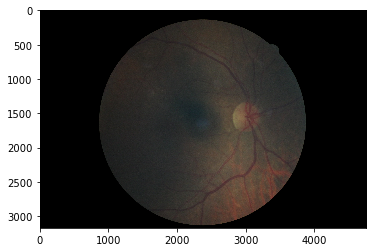

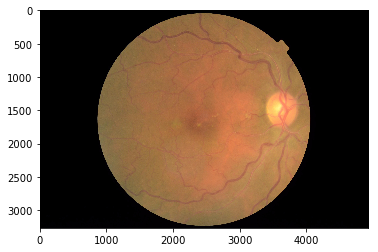

In [149]:
def showsamples(img1, img2):
    plt.figure()
    imgplot = plt.imshow(img1)
    plt.figure()
    imgplot = plt.imshow(img2)
    plt.show()
    return;
    
img1=mpimg.imread("Documents\\dataset2\\train\\nosymptoms\\10_right.jpeg")
img2=mpimg.imread("Documents\\dataset2\\train\\symptoms\\15_right.jpeg")
showsamples(img1,img2)

the upper sample is from right eye with no symptons and the lower is from right eye with symptons. The images have different lighting and contrast so it might make this harder for the model.

These values could be adjusted to a same mean.

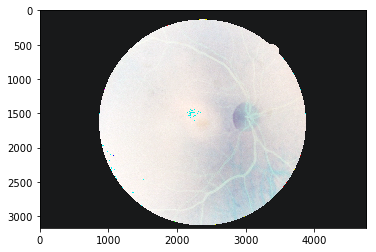

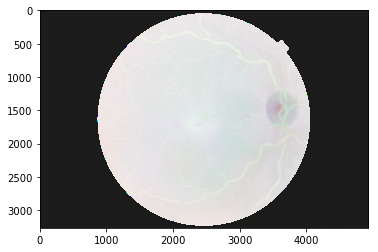

In [150]:
#Here we are using modified code from "Sakari Lukkarinen & Juha Kopu, Feb 15, 2018"

#making it a function to be able to use it with data generator
def image_to_mean(x):
    r = x[:, :, 0]
    g = x[:, :, 1]
    b = x[:, :, 2]
    r = (r - np.mean(r))/(1.0*np.std(r));
    g = (g - np.mean(g))/(1.0*np.std(g));
    b = (b - np.mean(b))/(1.0*np.std(b));
    #adding more contrast equally
    x[:, :, 0] = r*30
    x[:, :, 1] = g*30
    x[:, :, 2] = b*30
    
    x = x + 1.0
    return x

img1=mpimg.imread("Documents\\dataset2\\train\\nosymptoms\\10_right.jpeg")
img2=mpimg.imread("Documents\\dataset2\\train\\symptoms\\15_right.jpeg")

img1 = image_to_mean(img1)
img2 = image_to_mean(img2)

showsamples(img1,img2)


The colours and contrast are now not as dominating and the two different pictures resemble each other more 

#### make a datagenerator

Zoom 20% in and out, twist with 0.2 radians, rotate the pictures by 20 degrees and flip horizontally (=40% rotation). Also rescale to easen the model.

In [151]:
train_datagen = ImageDataGenerator(preprocessing_function = image_to_mean, zoom_range=0.2, shear_range=0.2, rotation_range=20.0, horizontal_flip=True, rescale=0.9)
validation_datagen = ImageDataGenerator(preprocessing_function = image_to_mean, rescale=0.9)
test_datagen = ImageDataGenerator(preprocessing_function = image_to_mean, rescale=0.9)

Customable parameters:

In [152]:
batch_size = 32
steps_per_epoch = 39 
validation_steps = 13

#directories
train_dir = "Documents/dataset2/train" 
validation_dir = "Documents/dataset2/validation" 
test_dir = "Documents/dataset2/test" 

In [153]:
# Generator for train dataset
print('Training dataset.')
train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size = batch_size,
        class_mode = 'binary')

# Generator for validation dataset
print('Validation dataset.')
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        batch_size = batch_size,
        class_mode = 'binary')

# Generator for test dataset
print('Test dataset.')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size = batch_size,
        class_mode = 'binary')

Training dataset.
Found 1237 images belonging to 2 classes.
Validation dataset.
Found 413 images belonging to 2 classes.
Test dataset.
Found 413 images belonging to 2 classes.


Check that all the data is intact

In [154]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


32 samples from generator, 256x256 images in 3-dimension RGB colour and labels are in 2 classes (previous Cell) and 10 samples.

## 4. Modeling and compilation




create the Neural network model and train it

    This one has Exponental linear unit as activation unit as it is deemed faster than ReLu.
    Also it includes 2 strides maxpooling which has proven to be useful in other similar problems.
    The dropout layers increase in layers, this was also very popular way in many similar networks.
    
    First try had also L1 regularizer on 1st dense layer and rest were L2. That model underfitted badly so more dense layers were added and regularization layers were removed as well as dropout rate was lowered.


In [155]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'elu', input_shape = (256,256,3)))
model.add(layers.Conv2D(32, (3, 3), activation = 'elu'))
model.add(layers.MaxPool2D((3, 3), strides=2))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(64, (3, 3), activation = 'elu'))
model.add(layers.Conv2D(64, (3, 3), activation = 'elu'))
model.add(layers.MaxPool2D((3, 3), strides=2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(96, (3, 3), activation = 'elu'))
model.add(layers.Conv2D(96, (3, 3), activation = 'elu'))
model.add(layers.MaxPool2D((3, 3), strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation = 'elu'))
model.add(layers.Conv2D(128, (3, 3), activation = 'elu'))
model.add(layers.MaxPool2D((3, 3), strides=2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(160, (3, 3), activation = 'elu'))
model.add(layers.Conv2D(160, (3, 3), activation = 'elu'))
model.add(layers.MaxPool2D((3, 3), strides=2))
          
#add dense frame with regularizers to generalize and dropout layers also
model.add(layers.Flatten())
model.add(layers.Dense(1028, activation='relu',activity_regularizer=keras.regularizers.l1(0.01)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_232 (Conv2D)          (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 125, 125, 32)      0         
_________________________________________________________________
dropout_121 (Dropout)        (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 123, 123, 64)      18496     
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 121, 121, 64)      36928     
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 60, 60, 64)        0         
__________

I will be trying Nadam as optimizer as Adam is proven to be very accurate in deep neural networks and a small study showed that introducing Nesterov momentum to Adam (=Nadam) makes it even faster and more accurate in many cases.


https://web.stanford.edu/~tdozat/files/TDozat-CS229-Paper.pdf

In [156]:
model.compile(loss = 'binary_crossentropy', optimizer = 'Nadam', metrics = ["accuracy"])

## 5. Training and Validation

The functions make it easier to test the models in slices of few epochs. This model is run for 30 epochs straight at start and then reviewed.

Its also nice to leave the verbose on to check that laptop is still running.

In [157]:
def fit(epochs_n):
    t1 = time.time()
    h = model.fit_generator(
          train_generator,
          steps_per_epoch = steps_per_epoch,
          epochs = epochs_n,
          validation_data = validation_generator,
          validation_steps = validation_steps)
    t2 = time.time()
    #store time inside history
    h.history.update({'time_elapsed': t2 - t1})
    return h

def savemodel(model_filename, history_filename):
    print('Model is saved to file:', model_filename)
    fname = os.path.join('Results', model_filename)
    model.save(fname)
    print('History is saved to file:', history_filename)
    fname = os.path.join('Results', history_filename)
    pickle.dump(h.history, open(fname, 'wb'))

#for testing purposes
savemodel('test3.h5','test4.p')


Model is saved to file: test3.h5
History is saved to file: test4.p


In [158]:
n_e = 30
#test with one
h1 = fit(n_e)
savemodel('Kuitunen_Case_2_Run_03_1.h5','Kuitunen_Case_2_Run_03_1.p')


Epoch 1/30
39/39 [==============================] - 1682s 43s/step - loss: 4735726274.6585 - acc: 0.7062 - val_loss: 0.6013 - val_acc: 0.7119

## 6. Evaluation

#### Plot the graphs to evaluate the model

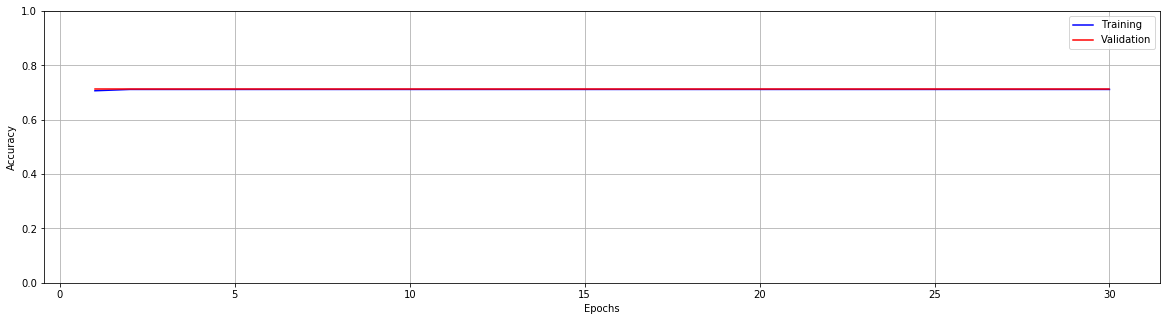

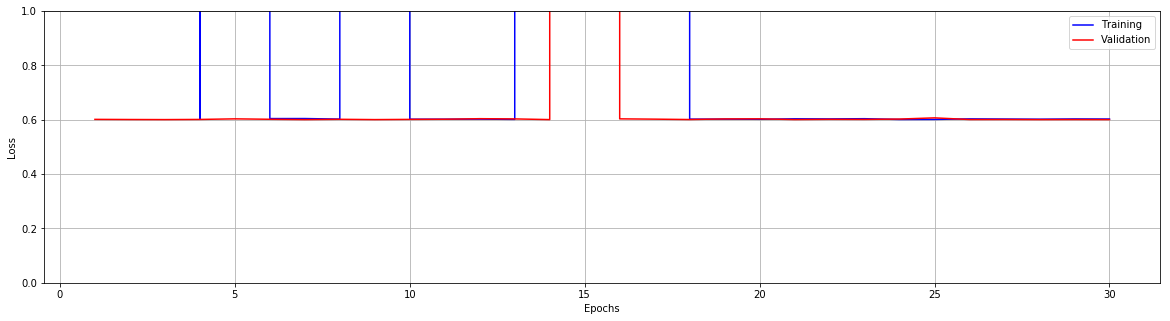

In [159]:
#make functions to plot result to easen the future work

#accuracy plot
def accplot(hist, n_epochs):
    epochs = range(1, n_epochs + 1)
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.figure(figsize = (20, 5))
    plt.plot(epochs, acc, "blue", label = "Training")
    plt.plot(epochs, val_acc, "red", label = "Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim([0, 1])
    plt.grid()
    plt.legend()
    plt.show

#loss plot
def lossplot(hist,n_epochs):
    epochs = range(1, n_epochs + 1)
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.figure(figsize = (20, 5))
    plt.plot(epochs, loss, "blue", label = "Training")
    plt.plot(epochs, val_loss, "red", label = "Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim([0, 1])
    plt.grid()
    plt.legend()
    plt.show

accplot(h1, n_e)
lossplot(h1, n_e)


Something funny happened with the training, the loss decreased to 0.6 in first epoch and stayd there for the whole 30 epochs. Also it gave from time to time some huge numbers (like 7690528934851477.0000) and then went back to 0.6. The validation accuracy also stayed in 71% for the whole time.

Check accuracy from validation and test the model with test set

In [163]:
#The accuracy at last epoch
h.history["val_acc"][-1]

0.71186440576941279

In [162]:
evaluate = model.evaluate_generator(test_generator,12)
print("Loss: ", evaluate[0], "Accuracy: ", evaluate[1])

Loss:  0.603734731674 Accuracy:  0.708333333333


#### Lets compare to an older one

In [166]:
model_older = keras.models.load_model('Results\\Kuitunen_Case_2_Run_01_3.h5')

In [167]:
evaluate_older = model_older.evaluate_generator(test_generator,12)
print("Loss: ", evaluate_older[0], "Accuracy: ", evaluate_older[1])

Loss:  82.546933492 Accuracy:  0.708333333333


## 7. Results and Discussion

The test samples are evaluated and they give the same 71%. A little disappointing but then again the model is so deep that this is made with 3 tries. 

This is actually as accurate as predicting everything "no symptons", which includes 71% of the test set. So in a way the model is totally useless. 413 (samples in total) / 294 (samples with no symptons) = 0.7118

If you look at the validation score it is equal to 6 decimals to the prediction of just going with "no symptons". So as a medical device this model will be the equivalent of asking your father for diagnosis: "OH! You're fine!"

###### comparison

The model really did learn at first during the first epoch, going through batches it started from 61% and went up nicely but got stuck at the 71%. This happened also with the previous older model that I tried so we'll just have to deal with this. 

The difference between older model and newer model was that the newer had less dropouts and regularisation so it would'nt underfit. The loss was smaller in this newer model but they both ended up with pretty much predicting true to all. Its fake news from fake doctor.

That's sad. 

## 8. Conclusions

There was a problem with the whole setup of the model. I am still glad I tried a different approach and went with exponential linear unit as activation and Nesterov's Adam as optimizer. I really wanted to try them out but It remains a mystery to me whether they failed the model or the structure. 

I thought I was also clever in the way I preprocessed the pictures in generator as I made them flip horizontally to match left and right eye and twisted them just slightly as also zoomed them. I glanced at the top 3 models from the kaggle contest and read about different approaches. I was pretty sure I'd get a good model but ended up going backwards in to the tree.

The model failed this time, but maybe next time then.